In [213]:
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

import glob

import os

import pandas as pd

import matplotlib.pyplot as plt
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import numpy as np

from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns


#import warnings
#warnings.filterwarnings("ignore")

my_random_state = 2022

## Calculate Features

In [176]:
def compute_features(df):
    # intraday return features
    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17res'
    features = temp.reset_index()

    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id') - df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # 17:30 ma raw return features
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = '17ma1raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = '17ma3raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = '17ma5raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='RawNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = '17ma20raw'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    features['17ma1-3raw'] = features['17ma1raw'] - features['17ma3raw']
    features['17ma1-5raw'] = features['17ma1raw'] - features['17ma5raw']
    features['17ma1-20raw'] = features['17ma1raw'] - features['17ma20raw']

    # 17:30 ma residual return features
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = '17ma1res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = '17ma3res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = '17ma5res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='ResidualNoWinsorCumReturn winsorized',index='Date',columns='Id').rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = '17ma20res'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    features['17ma1-3res'] = features['17ma1res'] - features['17ma3res']
    features['17ma1-5res'] = features['17ma1res'] - features['17ma5res']
    features['17ma1-20res'] = features['17ma1res'] - features['17ma20res']

    # market value
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id') * df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'market_value'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # intraday volume features
    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '10/17vol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='16:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') - df[df['Time']=='10:00:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')) / df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = '16/17vol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # turnover ma
    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=1).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma1'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=3).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma3'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=5).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma5'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = (df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id') / df[df['Time']=='17:30:00.000'].pivot_table(values='SharesOutstanding winsorized',index='Date',columns='Id')).rolling(window=20).mean()
    temp = temp.unstack()
    temp.name = 'turnover_ma20'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # original features 
    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='estVol winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'estVol'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid17'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='16:00:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid16'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='10:00:00.000'].pivot_table(values='CleanMid winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'cleanMid10'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    temp = df[df['Time']=='17:30:00.000'].pivot_table(values='CumVolume winsorized',index='Date',columns='Id')
    temp = temp.unstack()
    temp.name = 'vol17'
    temp = temp.reset_index()
    features = features.merge(temp,on=['Id','Date'])

    # Normalization
    #features.iloc[:,2:] = (features.iloc[:,2:] - features.iloc[:,2:].mean())/features.iloc[:,2:].std()

    # Merging with target
    target = df[df["Time"] == "17:30:00.000"][['Date','Id','ResidualNoWinsorCumReturn winsorized']].copy()
    merged = features.merge(target ,on =['Date','Id']).drop_duplicates()
    merged = merged.sort_values(['Id','Date'],ascending = [True, True])
    merged["y"] = merged.groupby(['Id'])["ResidualNoWinsorCumReturn winsorized"].shift(-1)
    merged = merged.dropna(how = 'any')
    merged = merged.sort_values('Date',ascending=True)
    merged_with_dates = merged
    merged_with_dates.to_csv("merged_with_dates.csv")
    merged = merged.drop(["Id", "Date","ResidualNoWinsorCumReturn winsorized"], axis = 1)
    merged.to_csv('beforeTrainning.csv')
    return merged, merged_with_dates

In [177]:
path = "/Users/sunshangwen/Dropbox (Personal)/Mac/Desktop/Git Uploads/MTH-9899-Data-Science-II-Project/merged_data_fillna_timeid.csv"
df = pd.read_csv(path, sep = ",")
m, mwd = compute_features(df)
m

,10/17res,10/17raw,16/17res,16/17raw,17ma1raw,17ma3raw,17ma5raw,17ma20raw,17ma1-3raw,17ma1-5raw,...,turnover_ma1,turnover_ma3,turnover_ma5,turnover_ma20,estVol,cleanMid17,cleanMid16,cleanMid10,vol17,y
19,-0.014479,0.004383,0.003725,0.001532,-0.002551,-4.328447e-03,0.012672,0.001606,0.001777,-0.015223,...,5127.454439,6982.580835,11541.301587,10753.510582,0.296036,33.452305,33.503600,33.599230,872180.0,-0.017619
521779,0.006544,0.019172,0.001098,-0.002364,-0.013599,-4.222190e-03,-0.015091,-0.002486,-0.009377,0.001492,...,4172.375545,3466.191410,3757.401356,2936.059761,0.178838,17.535980,17.494583,17.875440,4175388.0,-0.000857
523534,0.007003,0.021363,0.002370,0.001177,-0.018284,-6.530792e-04,0.000158,-0.004395,-0.017631,-0.018442,...,1364.178894,1576.224406,1625.117301,1100.684447,0.197799,10.543943,10.556362,10.771629,484379.0,0.005427
524559,0.000216,0.014031,0.003584,-0.001199,-0.008458,-5.796803e-03,-0.004567,0.005819,-0.002661,-0.003891,...,1991.979684,1418.626035,1253.361174,1726.009481,0.255014,8.605063,8.594749,8.726646,882447.0,0.022712
525278,-0.009049,0.006995,-0.003221,-0.005797,0.006212,-1.123333e-08,-0.007774,-0.000493,0.006212,0.013987,...,1544.120471,1322.711271,1227.455657,1456.009146,0.198565,20.052948,19.937037,20.193700,305566.0,-0.001233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474687,-0.003156,-0.002843,-0.002389,-0.000601,0.000601,1.659979e-03,0.001832,0.004811,-0.001059,-0.001230,...,755.496437,859.870155,1097.978782,2185.348603,0.124384,109.489080,109.423294,109.178300,69860.0,0.005219
620200,-0.005474,-0.005335,-0.005509,-0.002454,0.000700,2.318624e-03,-0.000727,0.000411,-0.001619,0.001427,...,1072.835540,1005.341016,1437.991572,2256.730451,0.097487,85.336110,85.126970,84.881970,139268.0,0.001534
11908,0.002591,0.004417,0.002889,0.005610,0.001834,5.823757e-03,0.004319,0.003771,-0.003990,-0.002486,...,3146.915786,3221.191763,2999.656179,3712.759845,0.159906,47.260170,47.526077,47.469370,139122.0,0.001472
719403,0.009592,0.006035,0.002739,0.002199,-0.011761,5.547418e-03,0.009233,-0.000683,-0.017308,-0.020993,...,882.373592,592.626950,938.420333,1328.093235,0.174713,12.221778,12.248676,12.295748,379523.0,0.001981


## Feature Selection

### Low Variance Filter

In [162]:
data_scaled = normalize(m)
data_scaled = pd.DataFrame(data_scaled, columns = m.columns)

In [163]:
data_scaled.var()

10/17res         0.031673
10/17raw         0.031760
16/17res         0.036223
16/17raw         0.036134
17ma1raw         0.028008
17ma3raw         0.033349
17ma5raw         0.035468
17ma20raw        0.040963
17ma1-3raw       0.031131
17ma1-5raw       0.029842
17ma1-20raw      0.028758
17ma1res         0.027611
17ma3res         0.033555
17ma5res         0.035576
17ma20res        0.042094
17ma1-3res       0.030766
17ma1-5res       0.029648
17ma1-20res      0.028948
market_value     0.031796
10/17vol         0.027070
16/17vol         0.045120
turnover_ma1     0.020880
turnover_ma3     0.023713
turnover_ma5     0.025420
turnover_ma20    0.030250
estVol           0.040140
cleanMid17       0.039311
cleanMid16       0.039308
cleanMid10       0.039306
vol17            0.039490
y                0.000007
dtype: float64

### High Correlation Filter

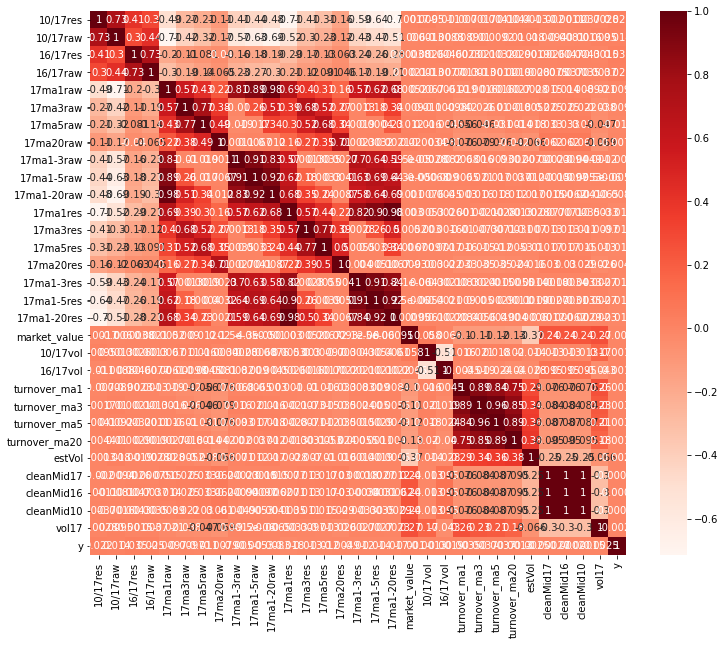

In [166]:
# feature hotmap captures only the pairwise correlation between the features
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = m.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [152]:
def calculateVIF(X):
    vif_data = pd.DataFrame({
        "Names": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_data

In [167]:
vif = calculateVIF(m)

In [172]:
while(vif["VIF"].max() >= 20):
    drop_var = vif[vif.VIF == vif["VIF"].max()]["Names"]
    m = m.drop(drop_var, axis = 1)
    vif = calculateVIF(m)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [182]:
m

,10/17res,10/17raw,16/17res,16/17raw,17ma1raw,17ma3raw,17ma5raw,17ma20raw,17ma1-3raw,17ma1-5raw,...,turnover_ma1,turnover_ma3,turnover_ma5,turnover_ma20,estVol,cleanMid17,cleanMid16,cleanMid10,vol17,y
19,-0.014479,0.004383,0.003725,0.001532,-0.002551,-4.328447e-03,0.012672,0.001606,0.001777,-0.015223,...,5127.454439,6982.580835,11541.301587,10753.510582,0.296036,33.452305,33.503600,33.599230,872180.0,-0.017619
521779,0.006544,0.019172,0.001098,-0.002364,-0.013599,-4.222190e-03,-0.015091,-0.002486,-0.009377,0.001492,...,4172.375545,3466.191410,3757.401356,2936.059761,0.178838,17.535980,17.494583,17.875440,4175388.0,-0.000857
523534,0.007003,0.021363,0.002370,0.001177,-0.018284,-6.530792e-04,0.000158,-0.004395,-0.017631,-0.018442,...,1364.178894,1576.224406,1625.117301,1100.684447,0.197799,10.543943,10.556362,10.771629,484379.0,0.005427
524559,0.000216,0.014031,0.003584,-0.001199,-0.008458,-5.796803e-03,-0.004567,0.005819,-0.002661,-0.003891,...,1991.979684,1418.626035,1253.361174,1726.009481,0.255014,8.605063,8.594749,8.726646,882447.0,0.022712
525278,-0.009049,0.006995,-0.003221,-0.005797,0.006212,-1.123333e-08,-0.007774,-0.000493,0.006212,0.013987,...,1544.120471,1322.711271,1227.455657,1456.009146,0.198565,20.052948,19.937037,20.193700,305566.0,-0.001233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474687,-0.003156,-0.002843,-0.002389,-0.000601,0.000601,1.659979e-03,0.001832,0.004811,-0.001059,-0.001230,...,755.496437,859.870155,1097.978782,2185.348603,0.124384,109.489080,109.423294,109.178300,69860.0,0.005219
620200,-0.005474,-0.005335,-0.005509,-0.002454,0.000700,2.318624e-03,-0.000727,0.000411,-0.001619,0.001427,...,1072.835540,1005.341016,1437.991572,2256.730451,0.097487,85.336110,85.126970,84.881970,139268.0,0.001534
11908,0.002591,0.004417,0.002889,0.005610,0.001834,5.823757e-03,0.004319,0.003771,-0.003990,-0.002486,...,3146.915786,3221.191763,2999.656179,3712.759845,0.159906,47.260170,47.526077,47.469370,139122.0,0.001472
719403,0.009592,0.006035,0.002739,0.002199,-0.011761,5.547418e-03,0.009233,-0.000683,-0.017308,-0.020993,...,882.373592,592.626950,938.420333,1328.093235,0.174713,12.221778,12.248676,12.295748,379523.0,0.001981


## Train Linear Model

### Train/Test Split

In [189]:
train = m.loc[list(mwd[mwd["Date"] < 20170101].index)]
test = m.loc[list(mwd[mwd["Date"] >= 20170101].index)]

In [191]:
X_train = train.iloc[: , :-1]
y_train = train["y"]
X_test = test.iloc[: , :-1]
y_test = test["y"]

In [192]:
# scale the features in train set
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)

# do the same scaling to test set
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

### Cross-Validation

In [193]:
# create a subclass of TimeSeriesSplit
class TimeSeriesSplitImproved(TimeSeriesSplit):
    """Time Series cross-validator
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals, in train/test sets.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide `.
    Parameters
    ----------
    n_splits : int, default=3
        Number of splits. Must be at least 1.
    Examples
    --------
    >>> from sklearn.model_selection import TimeSeriesSplit
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4])
    >>> tscv = TimeSeriesSplit(n_splits=3)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(n_splits=3)
    >>> for train_index, test_index in tscv.split(X):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    >>> for train_index, test_index in tscv.split(X, fixed_length=True):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [1] TEST: [2]
    TRAIN: [2] TEST: [3]
    >>> for train_index, test_index in tscv.split(X, fixed_length=True,
    ...     train_splits=2):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [1 2] TEST: [3]
 
    Notes
    -----
    When ``fixed_length`` is ``False``, the training set has size
    ``i * train_splits * n_samples // (n_splits + 1) + n_samples %
    (n_splits + 1)`` in the ``i``th split, with a test set of size
    ``n_samples//(n_splits + 1) * test_splits``, where ``n_samples``
    is the number of samples. If fixed_length is True, replace ``i``
    in the above formulation with 1, and ignore ``n_samples %
    (n_splits + 1)`` except for the first training set. The number
    of test sets is ``n_splits + 2 - train_splits - test_splits``.
    """
 
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=1, test_splits=1):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like, with shape (n_samples,), optional
            Always ignored, exists for compatibility.
        fixed_length : bool, hether training sets should always have
            common length
        train_splits : positive int, for the minimum number of
            splits to include in training sets
        test_splits : positive int, for the number of splits to
            include in the test set
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        if not (((n_folds - train_splits - test_splits) > 0) and (test_splits > 0)):
            raise ValueError(
                ("Both train_splits and test_splits must be positive"
                 " integers."))
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)), test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start], indices[test_start: test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start], indices[test_start:test_start + test_size])

In [194]:
def self_cross_validation(model, X, y, n_splits = 5, how = "rolling"):

    if how == "walk_forwarding":
        tscv = TimeSeriesSplit(n_splits = n_splits)
        splits = tscv.split(X)
    elif how == "rolling":
        tscv = TimeSeriesSplitImproved(n_splits = n_splits)
        splits = tscv.split(X, fixed_length = True)
    else:
        return None
        
    results = {"test_score": [], "train_score": [], "params": []}
    
    for train_index, val_index in splits:
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train, y_train)
        results["params"].append(model.coef_)
        results["test_score"].append(weighted_r2_scorer(model, X_val, y_val))
        results["train_score"].append(weighted_r2_scorer(model, X_train, y_train))

    return results

### Hyper-parameter Tuning

In [255]:
def regmodel_hyperparameter_tuning(alphas_to_try, X, y, n_splits = 5, how_cv = "walk_forwarding", scoring = "weighted_r2", 
                                   model_name = 'Ridge', X_test = None, y_test = None, draw_plot = False, filename = None):
    
    # tuning the hyper-parameter by grid searching
    # optimising on one basis but then comparing performance on another
    # scoring method: weighted R-squared
    
    validation_scores = []
    train_scores = []
    results_list = []
    
    if X_test is not None:
        test_scores = []
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        if model_name == 'Lasso':
            regmodel = Lasso(alpha = curr_alpha, tol = 1e-5, max_iter = 50000)
            
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
            
        elif model_name == 'SimpleLR':
            regmodel = LinearRegression()
            
        else:
            return None        

        results = self_cross_validation(regmodel, X, y, n_splits = n_splits, how = how_cv)
        #tscv = TimeSeriesSplit(n_splits = n_splits)
        #results = cross_validate(regmodel, X, y, scoring = "r2", cv=tscv, return_train_score = True)
        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel = regmodel.fit(X, y)
            y_pred = regmodel.predict(X_test)
            r2_weight = 1 / X_test["estVol"]
            test_scores.append(r2_score(y_test, y_pred, sample_weight = r2_weight))

    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(validation_scores, train_scores, alphas_to_try, chosen_alpha, 
                            model_name, scoring, test_scores, filename)
        
    print("Chosen alpha: %.5f" % chosen_alpha)
    print("Validation score: %.5f" % max_validation_score)
    print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha




def regmodel_param_plot(validation_score, train_score, alphas_to_try, chosen_alpha, scoring,
                        model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, label = 'training_data')
    plt.axvline(x = chosen_alpha, linestyle = '--')
    
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, label = 'test_data')
        
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularization')
    plt.legend()
    
    if filename is not None:
        plt.savefig(str(filename) + ".png")
        
    plt.show()
    

In [256]:
def weighted_r2_scorer(model, X, y):

    r2_weight = 1 / np.array(X["estVol"])
    r2_weight = r2_weight / np.sum(r2_weight)
    
    y_pred = model.predict(X)
        
    return r2_score(y, y_pred, sample_weight = r2_weight)

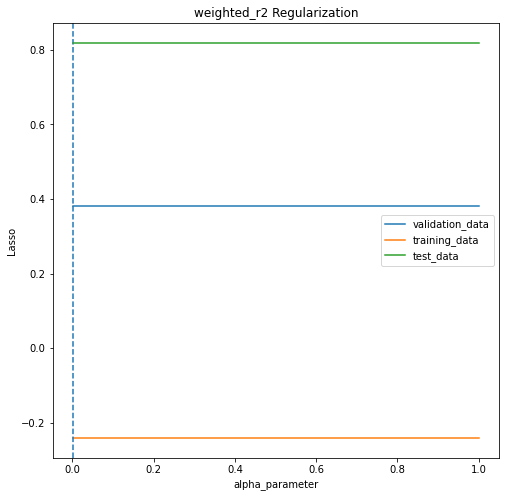

Chosen alpha: 0.00100
Validation score: 0.38157
Test score at chosen alpha: 0.81914


(0.001, 0.381573651503647, 0.8191379590621912)

In [257]:
# wide search
# lasso model
lasso_alphas = np.linspace(0.001, 1, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train_scaled, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Lasso', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

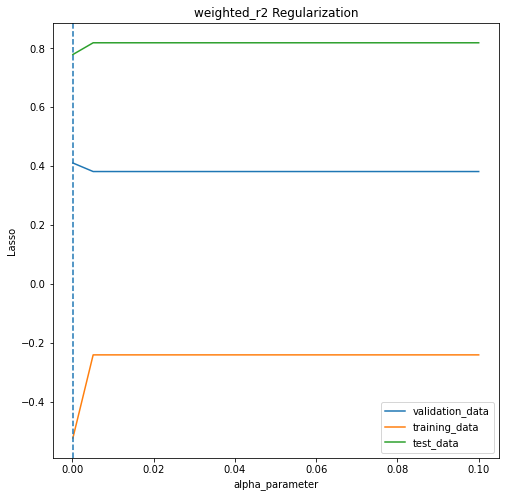

Chosen alpha: 0.00010
Validation score: 0.41064
Test score at chosen alpha: 0.77922


(0.0001, 0.41063771037202434, 0.7792150139251484)

In [254]:
# granular search
# lasso model
lasso_alphas = np.linspace(0.0001, 0.1, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train_scaled, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Lasso', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

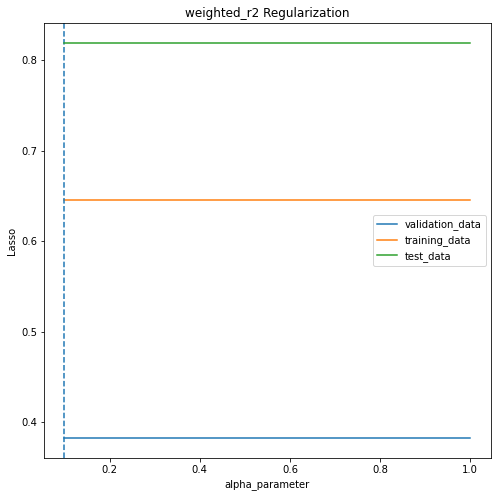

Chosen alpha: 0.10000
Validation score: 0.38236
Test score at chosen alpha: 0.81914


(0.1, 0.3823608300044198, 0.8191379590621912)

In [245]:
# wide search
# lasso model
lasso_alphas = np.linspace(0.1, 1, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train_scaled, y_train, 
                               n_splits = 5,  how_cv = "rolling", model_name = 'Lasso', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

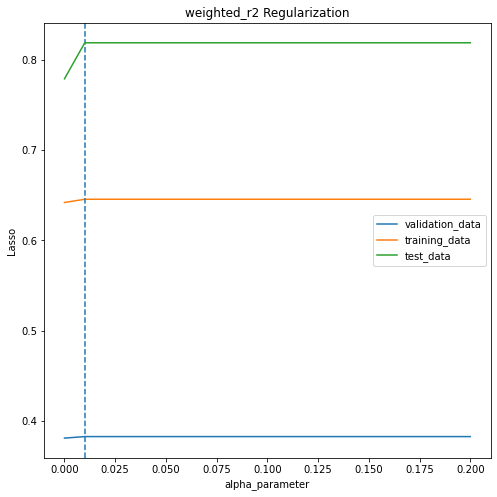

Chosen alpha: 0.01009
Validation score: 0.38236
Test score at chosen alpha: 0.81914


(0.010095, 0.3823608300044198, 0.8191379590621912)

In [246]:
# granular search
# lasso model
lasso_alphas = np.linspace(0.0001, 0.2, 21)
regmodel_hyperparameter_tuning(lasso_alphas, X_train_scaled, y_train, 
                               n_splits = 5,  how_cv = "rolling", model_name = 'Lasso', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

In [247]:
lasso_regmodel = Lasso(alpha = 0.1)
lasso_regmodel.fit(X_train_scaled, y_train)
y_pred = lasso_regmodel.predict(X_test_scaled)
r2_weight = 1 / X_test_scaled["estVol"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))

0.8191379590621912


## Feature Importance

In [248]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lasso_regmodel, random_state = my_random_state).fit(X_train_scaled, y_train)
eli5.show_weights(perm, feature_names = X_test_scaled.columns.tolist())

/opt/anaconda3/lib/python3.8/site-packages/eli5/formatters/html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,17ma20res
0 ± 0.0000,16/17raw
0 ± 0.0000,17ma1raw
0 ± 0.0000,17ma3raw
0 ± 0.0000,17ma5raw
0 ± 0.0000,17ma20raw
0 ± 0.0000,17ma1-3raw
0 ± 0.0000,17ma1-5raw
0 ± 0.0000,17ma1-20raw
0 ± 0.0000,17ma1res


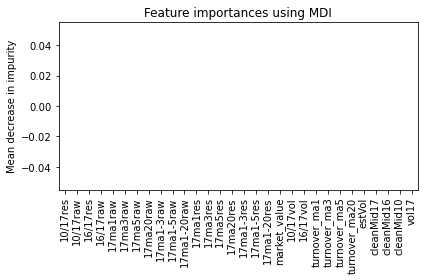

In [239]:
perm = permutation_importance(lasso_regmodel, X_test_scaled, y_test, n_repeats = 10, random_state = my_random_state)
lasso_importances = pd.Series(perm.importances_mean, index = X_test_scaled.columns.tolist())
std = perm.importances_std

fig, ax = plt.subplots()
lasso_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.28461e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.50598e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.75075e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.23033e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.2913e-19): result may not be accurate.

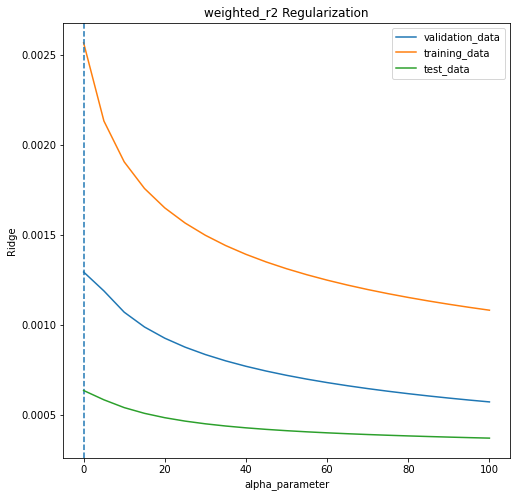

Chosen alpha: 0.00000
Validation score: 0.00129
Test score at chosen alpha: 0.00063


(0.0, 0.0012929868415615386, 0.0006348474474995314)

In [258]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 100, 21)
regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.11692e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53013e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.00276e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.483e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.49127e-20): result may not be accurate.


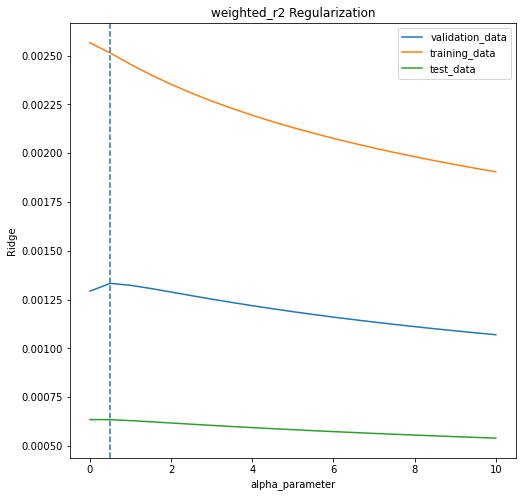

Chosen alpha: 0.50000
Validation score: 0.00133
Test score at chosen alpha: 0.00063


(0.5, 0.001333098048699255, 0.0006343175822682845)

In [259]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 10, 21)
regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.42807e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.71332e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.67672e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.41714e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.58385e-17): result may not be accurate

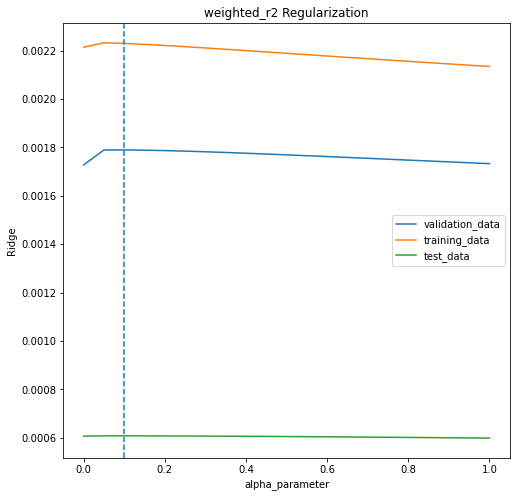

Chosen alpha: 0.10000
Validation score: 0.00179
Test score at chosen alpha: 0.00061


(0.1, 0.0017893220061871995, 0.0006085630614132143)

In [148]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 1.0, 21)
regmodel_hyperparameter_tuning(ridge_alphas, X_train_scaled, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

In [271]:
regmodel = LinearRegression()
regmodel.fit(X_train, y_train)
y_pred = regmodel.predict(X_test)
r2_weight = 1 / X_test["estVol"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))
perm = PermutationImportance(regmodel, random_state = my_random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

0.0006355532522533958


Weight,Feature
0.4888 ± 0.0027,cleanMid10
0.1780 ± 0.0033,cleanMid16
0.0793 ± 0.0023,cleanMid17
0.0013 ± 0.0003,16/17res
0.0007 ± 0.0002,17ma1-20raw
0.0005 ± 0.0002,turnover_ma5
0.0004 ± 0.0001,17ma1-20res
0.0003 ± 0.0001,turnover_ma20
0.0001 ± 0.0000,17ma1res
0.0001 ± 0.0000,10/17raw


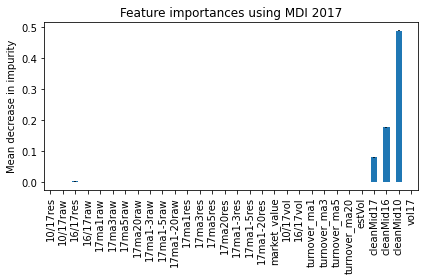

In [272]:
perm = permutation_importance(regmodel, X_test, y_test, n_repeats = 10, random_state = my_random_state)
lasso_importances = pd.Series(perm.importances_mean, index = X_test.columns.tolist())
std = perm.importances_std

fig, ax = plt.subplots()
lasso_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI 2017")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [266]:
regmodel = LinearRegression()
regmodel.fit(X_train_scaled, y_train)
y_pred = regmodel.predict(X_test_scaled)
r2_weight = 1 / X_test["estVol"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))
perm = PermutationImportance(regmodel, random_state = my_random_state).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_test_scaled.columns.tolist())

0.0006873154339311904


Weight,Feature
51614660946543952003072.0000 ± 173921434359904272384.0000,17ma1-5raw
26931272406884828577792.0000 ± 123672597463627743232.0000,17ma1raw
18930406773938400002048.0000 ± 29834690220401590272.0000,17ma1-20res
12319750599959398842368.0000 ± 71660370663693934592.0000,17ma5raw
11986771388330567270400.0000 ± 33239438071668023296.0000,17ma1-5res
11857002761420644810752.0000 ± 30264262702694989824.0000,17ma1-3raw
5767801269181724229632.0000 ± 25328538571262988288.0000,17ma3raw
4391134678853264867328.0000 ± 26015661921923043328.0000,17ma1-3res
3884232295721305374720.0000 ± 6594154507719196672.0000,17ma1res
2959175657901347831808.0000 ± 11683442386099044352.0000,17ma5res


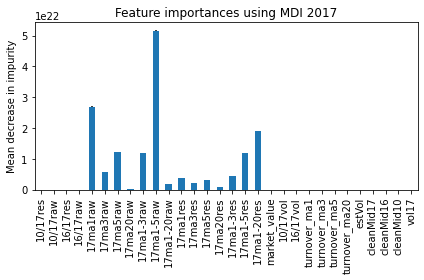

In [268]:
perm = permutation_importance(regmodel, X_test_scaled, y_test, n_repeats = 10, random_state = my_random_state)
lasso_importances = pd.Series(perm.importances_mean, index = X_test_scaled.columns.tolist())
std = perm.importances_std

fig, ax = plt.subplots()
lasso_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI 2017")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()